<IPython.core.display.Javascript object>


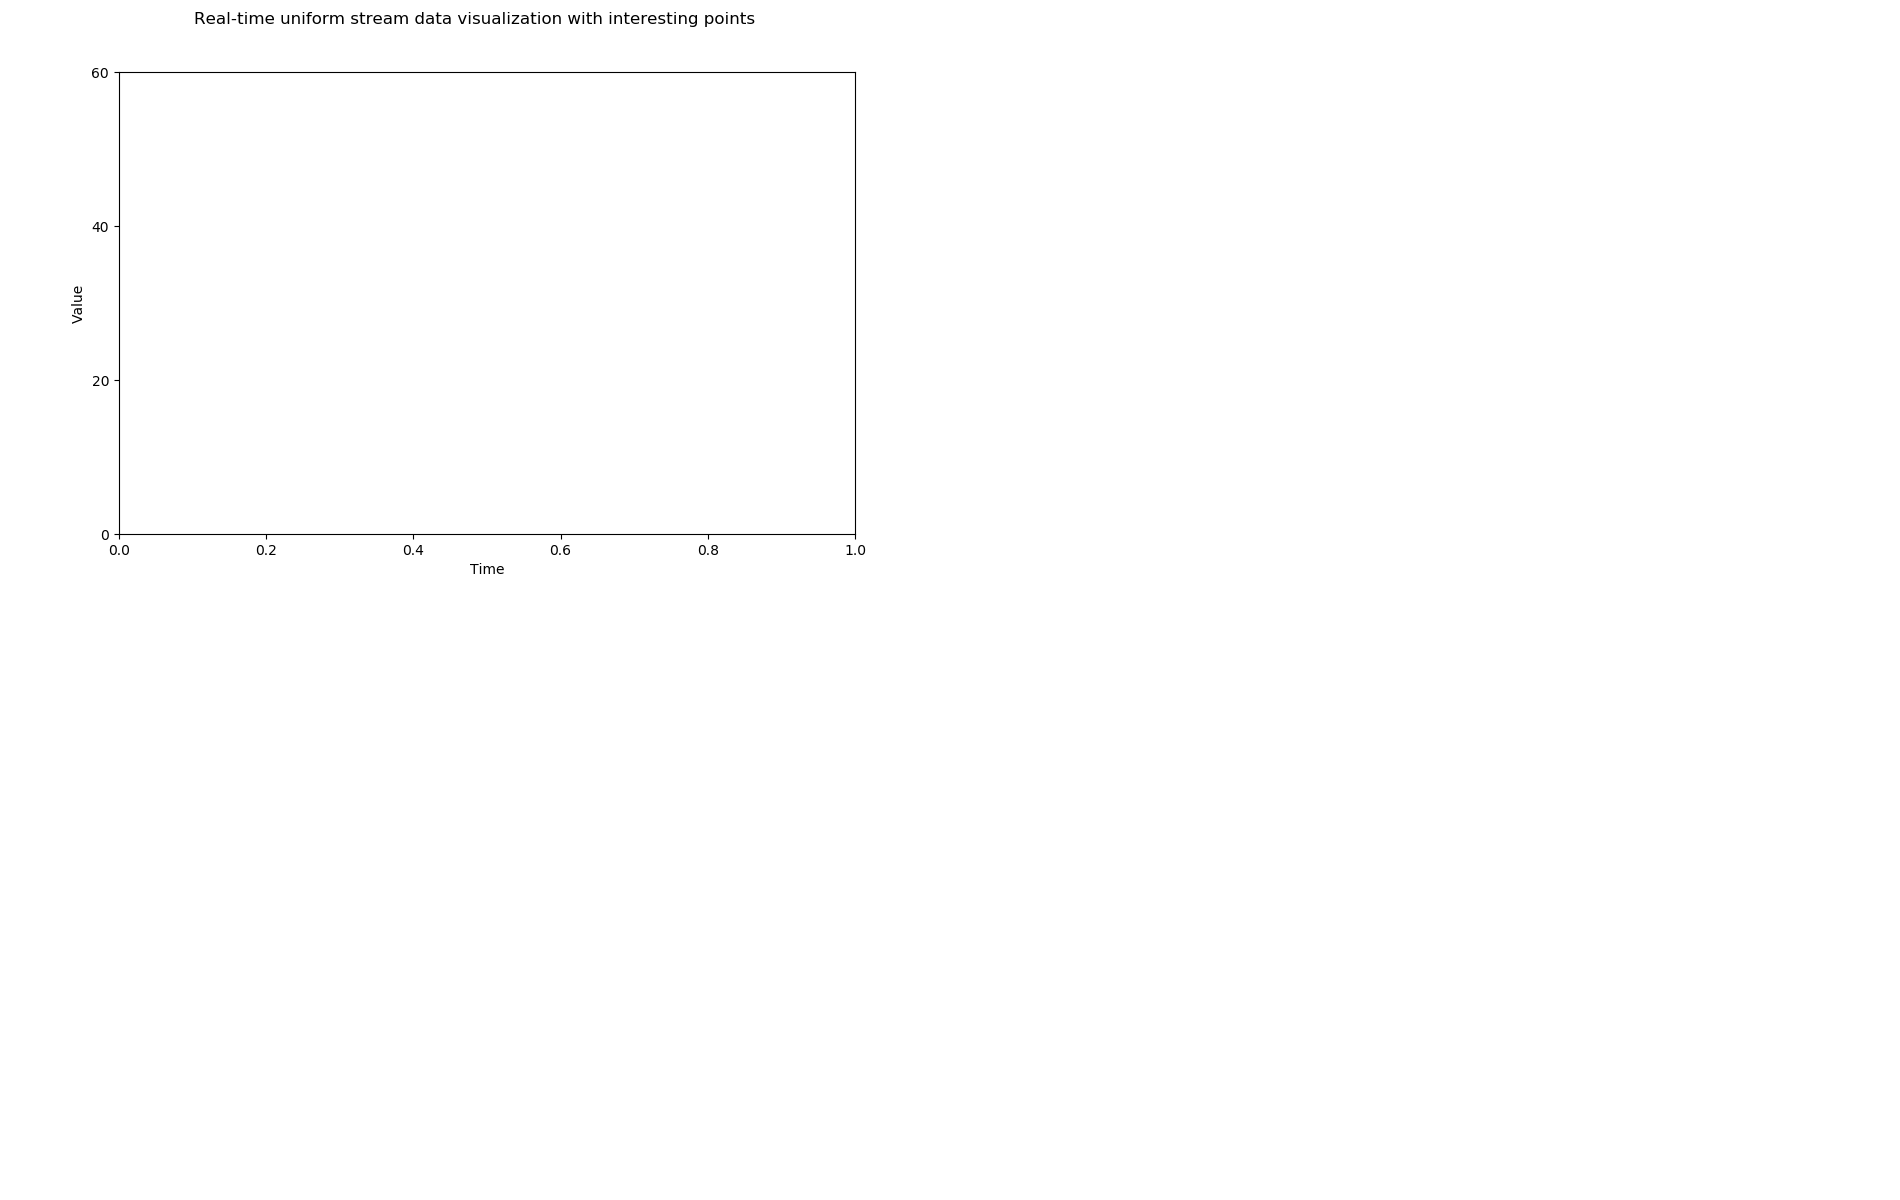

In [1]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import pymongo
import gmplot
from pymongo import MongoClient
import pandas as pd #for data loading
from pprint import pprint
import numpy as np


# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook


topic = 'climate'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,60) 
        ax.set_yticks([0,20,40,60])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
        
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = eval(str(message.value.decode('utf-8')))
            x.append(data['created_time']) 
            y.append(float(data['air_temperature_celcius']))
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                ax.set_ylim(0,60) 
                ax.set_yticks([0,20,40,60])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
        
        
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    

In [2]:
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 10) # latitude and longitude of melbourne city

In [3]:
client = MongoClient()
db = client.fit5148_assignment_db
collection = db.climate

In [4]:
date_list=[]
num_list=[]
results = collection.aggregate([
        {"$unwind":"$hot_spots"},
        {"$group":{"_id":"$date","count":{"$sum":1}}},
        {"$sort":{"count":pymongo.DESCENDING}},
        {"$limit":10}
        
])

for i in results :
    
    date_list.append(i["_id"].strftime("%Y-%m-%d"))
    num_list.append(i["count"])




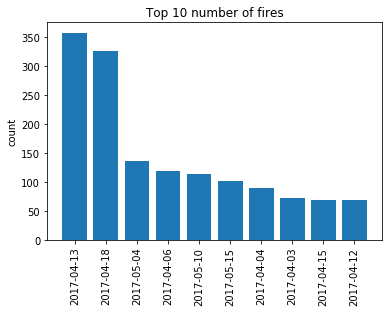

In [5]:
date = date_list
y_pos = np.arange(len(date))
performance = num_list

plt.bar(y_pos, performance, align='center', alpha=1)
plt.xticks(y_pos, date)
plt.ylabel('count')
plt.title('Top 10 number of fires')
plt.xticks(rotation=90)
plt.show()

In [6]:
fire = []
a = collection.aggregate([{"$unwind":"$hot_spots"}])
for i in a:
    hot_spot = i['hot_spots'] 
    information = "surface temp: " + str(hot_spot['surface_temperature_celcius']) + ", confidence: " + str(hot_spot['confidence']) + ", air temp: " + str(i['air_temperature_celcius']) + ", relative_humidity: " + str(i['relative_humidity'])  
    fire.append((float(hot_spot['latitude']), float(hot_spot['longitude']), information))



In [7]:
# The step below is required by the gmap scatter function to prepare data in correct format
lats, lons, info = zip(*fire) 

In [8]:
#i[0] is lats, i[1]is lons and i[2]is information for the locations
for i in fire:
    gmap.marker(i[0],i[1],title=i[2])

In [9]:
import webbrowser
# Drawing the map
gmap.draw("map.html")
webbrowser.open_new("map.html")

True